In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch as th
import pandas as pd

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

from utils.inspect import quick_inspection, q_values_at_state, rewards_at_state
from RLClasses.clases_parser import ParserFOL_1f
from RLClasses.PER_SB3 import PERDQN, PrioritizedReplayBuffer

from matplotlib import pyplot as plt
%matplotlib inline

# os.environ["PROVER9"] = "/LADR-2009-02A/bin"

In [2]:
NUM_FRASE = 3
ENV_NAME_PER = f'FOL_1f_ejemplo_{NUM_FRASE}_PER_v1'
ENV_NAME_DQN = f'FOL_1f_ejemplo_{NUM_FRASE}_DQN_v1'

In [3]:
num_frases = [3, 7, 8]
df = pd.read_csv('smallest_ordered.csv')
df.drop(columns=['Unnamed: 0', 'length'], inplace=True)
df = df.iloc[num_frases]
df.reset_index(drop=True, inplace=True)
df

,frase,frase-FOL,pregunta,respuesta,tipo_pregunta
0,Some cats are not pets.\nAll cats are mammals.,∃x (Cat(x) ∧ ¬Pet(x))\n∀x (Cat(x) → Mammal(x)),Some mammals are not pets.,∃x ∃y (Mammal(x) ∧ Mammal(y) ∧ ¬Pet(x) ∧ ¬Pet(y)),individuo
1,All tables are round.\nSome pieces of furnitur...,∀x (Table(x) → Round(x))\n∃x ∃y (Furniture(x) ...,Some pieces of furniture are round.,∃x ∃y (Furniture(x) ∧ Furniture(y) ∧ Round(x) ...,individuo
2,Trees are plants.\nSome living things are trees.,∀x (Tree(x) → Plant(x))\n∃x ∃y (Living(x) ∧ Li...,Some living things are plants.,∃x ∃y (Living(x) ∧ Living(y) ∧ Plant(x) ∧ Plan...,individuo


In [4]:
env = ParserFOL_1f(df)
env.render()

 ______________ 
|              |
|--------------|
| EMPTY(empty) |
|______________|
Índice: 0
Nivel: 0
Lista palabras: ['Trees', 'are', 'plants']
 ______________ 
|              |
|--------------|
| EMPTY(empty) |
|______________|


1. Entrenamiento con NUM_FRASE = 8: "trees are plants":
    * env.max_turns = 1
    * model.gamma = 0
    * TIME_STEPS = 1_000
    * env.max_turns = 2
    * model.gamma = 0
    * TIME_STEPS = 5_000
    * env.max_turns = 5
    * model.gamma = 0.1
    * TIME_STEPS = 150_000

2. Entrenamiento con NUM_FRASE = 7: "all tables are round":
    * añadir la frase 7 al entorno (2 frases)
    * model.gamma = 0.1
    * env.max_turns = 1
    * TIME_STEPS = 1_000
    * env.max_turns = 2
    * TIME_STEPS = 1_000
    * env.max_turns = 3
    * TIME_STEPS = 1_000
    * env.max_turns = 5
    * TIME_STEPS = 150_000
    * env.max_turns = 7
    * TIME_STEPS = 300_000

3. Entrenamiento con NUM_FRASE = 3: "some cats are not pets":
    * añadir la frase 3 al entorno (3 frases)
    * model.gamma = 0.1
    * env.max_turns = 1
    * TIME_STEPS = 1_000
    * env.max_turns = 2
    * TIME_STEPS = 1_000
    * env.max_turns = 3
    * TIME_STEPS = 1_000
    * env.max_turns = 5
    * TIME_STEPS = 150_000
    * env.max_turns = 7
    * TIME_STEPS = 300_000

### Parametros del agente

In [5]:
# Funcion asocida a la politica de exploracion con base en el proceso de entrenamiento
def learning_rate_fn(process_remaining):
    initial = 1e-4
    final =  1e-4
    return final + (initial - final) * process_remaining

# Configuracion de los parametros de entrenamiento del entorno
TIME_STEPS = 1_000
n_envs = 1

config = {
    "training_mode": "aleatorio",
    "total_timesteps": TIME_STEPS,
    "guide_reward_frac": 1.0,
    "max_episodes": 1
}

# Configuracion de la red de la politica de entrenamiento
policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=[1024,64],
)

# Configuracion de los parametros de entrenamiento del modelo
model_kwargs_PER = dict(
    policy="MlpPolicy",
    replay_buffer_class=PrioritizedReplayBuffer,
    learning_starts=100,
    train_freq=4,
    buffer_size=TIME_STEPS // 10,
    target_update_interval=TIME_STEPS // 100,
    gradient_steps=1,
    batch_size=32,
    exploration_fraction = 0.8,
    exploration_initial_eps= 0.2,
    exploration_final_eps= 0.05,
    gamma=0.99,
    max_grad_norm=0.5,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-4,
    # learning_rate=learning_rate_fn,
    seed=42,
    stats_window_size=50,
    verbose=0
)

### Model PER

In [6]:
# Instanciar el agente de entrenamiento
env = ParserFOL_1f(df)
env.set_training_parameters(**config)

env.max_turns = 1

env_PER = Monitor(env, f"logs_{ENV_NAME_PER}/env_log", allow_early_resets=True)

train_env = env_PER

model = PERDQN(env=train_env, **model_kwargs_PER)
# model = PERDQN.load(f"model_{ENV_NAME_PER}", env=train_env)
# model = PERDQN.load("BasicAllAre", env=train_env)
# model = PERDQN.load("BasicAllAre-and-some", env=train_env)

In [7]:
TIME_STEPS = 100_000
model.buffer_size = TIME_STEPS // 10
model.target_update_interval = TIME_STEPS // 100
model.gamma = 0

In [8]:
# Train the agent and display a progress bar
model.learn(
    total_timesteps=TIME_STEPS,
    progress_bar=True
)

Output()

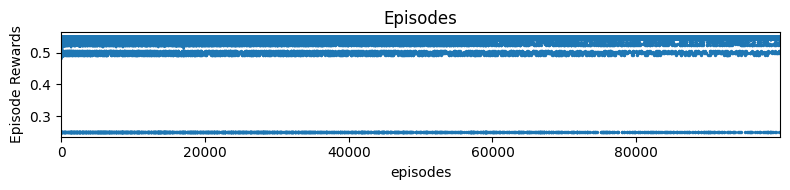

In [10]:
# ver = "Timesteps" 
ver ="Episodes"
if ver == "Timesteps":
    results_plotter.plot_results([f"logs_{ENV_NAME_PER}"], TIME_STEPS, results_plotter.X_TIMESTEPS, "Timesteps")
elif ver == "Episodes":
    results_plotter.plot_results([f"logs_{ENV_NAME_PER}"], TIME_STEPS, results_plotter.X_EPISODES, "Episodes")

In [11]:
acciones = [
    'crear_drs_antecedente',
    # 'enmascarar',
    # 'incluir_sustantivo',
    # 'enmascarar',
    # 'crear_drs_consecuente',
    # 'incluir_sustantivo_sin_ref',
    # "mover_derecha",
]

states, list_actions = quick_inspection(model, env, acciones)


Iteración 1

------------------------------------------------------------
Índice: 0
Nivel: 0
Some cats are not pets
Some cats are not pets
EMPTY(empty)
------------------------------------------------------------

accion: crear_drs_antecedente
Recompensa: 0.49074074074074076

Índice: 0
Nivel: 1
Some cats are not pets
Some cats are not pets
(EMPTY(empty) -> EMPTY(empty))
terminated: False, truncated: True
Total reward: 0.49074074074074076


In [ ]:
obs = states[0]
q_values_at_state(model, env, obs)

In [17]:
# acciones_previas = list_actions[:1]
acciones_previas = []
rewards_at_state(env, acciones_previas)

+----------------------------+---------------------+
|           Acción           |      Recompensa     |
+----------------------------+---------------------+
|     incluir_sustantivo     |  0.5327380952380952 |
| incluir_sustantivo_sin_ref |  0.5278846153846154 |
|         enmascarar         |  0.5041666666666667 |
|       mover_derecha        |         0.5         |
|   crear_drs_antecedente    | 0.49074074074074076 |
|   crear_drs_consecuente    |         0.25        |
+----------------------------+---------------------+


In [ ]:
# # Save the agent
# # model.save(f"model_{ENV_NAME_PER}")
model.save("BasicAllAre")
# model.save("BasicAllAre-some")

log_file = os.path.join(f"logs_{ENV_NAME_PER}", f"env_log.monitor.csv")

fig = plt.figure(figsize=(8, 8))
df_results = pd.read_csv(log_file, skiprows=1)
# plt.subplot(int(nrows), 2, i+1, label=log_file)
# df_results['r'].rolling(window=50).mean().plot(title=f"Rewards")
df_results['r'].plot(title=f"Rewards")
plt.tight_layout()
plt.show()